In [6]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
import serial
import time
import numpy as np
import keras
from keras.preprocessing import image
import cv2
import imutils
import numpy as np

In [7]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory('HD/train',target_size = (64, 64),batch_size = 32,
                                                 class_mode = 'binary')
test_set = test_datagen.flow_from_directory('HD/test',
                                             target_size = (64, 64),batch_size = 32,class_mode = 'binary')





Found 5982 images belonging to 6 classes.
Found 0 images belonging to 0 classes.


In [8]:

# Initialising the CNN
classifier = Sequential()
# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))
# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# Step 3 - Flattening
classifier.add(Flatten())
# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 6, activation = 'softmax'))
# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])




In [9]:

# Part 2 - Fitting the CNN to the images

r=classifier.fit(training_set,epochs = 25,validation_data = test_set)

Epoch 1/25
187/187 [==============================] - 36s 189ms/step - loss: 0.2948 - accuracy: 0.9151
Epoch 2/25
187/187 [==============================] - 22s 117ms/step - loss: 0.0793 - accuracy: 0.9766
Epoch 3/25
187/187 [==============================] - 23s 125ms/step - loss: 0.0516 - accuracy: 0.9838
Epoch 4/25
187/187 [==============================] - 21s 111ms/step - loss: 0.0486 - accuracy: 0.9856
Epoch 5/25
187/187 [==============================] - 21s 110ms/step - loss: 0.0435 - accuracy: 0.9893
Epoch 6/25
187/187 [==============================] - 21s 113ms/step - loss: 0.0372 - accuracy: 0.9908
Epoch 7/25
187/187 [==============================] - 21s 112ms/step - loss: 0.0338 - accuracy: 0.9891
Epoch 8/25
187/187 [==============================] - 21s 111ms/step - loss: 0.0294 - accuracy: 0.9901
Epoch 9/25
187/187 [==============================] - 21s 111ms/step - loss: 0.0390 - accuracy: 0.9891
Epoch 10/25
187/187 [==============================] - 21s 113ms/step - l

KeyError: 'val_accuracy'

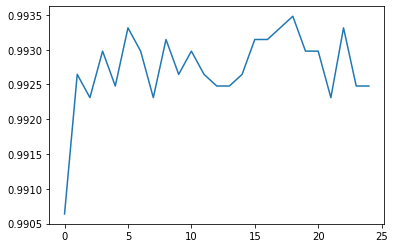

In [65]:
plt.plot(r.history['accuracy'], label='train acc')

plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')


In [171]:
def write_read(x):
    data =  arduino.write(bytes(x, 'utf-8'))
    return data


In [172]:
arduino = serial.Serial(port='COM4', baudrate=9600, timeout=.5)

In [170]:
# Part 3 - Making new predictions
test_image = keras.utils.load_img(r'C:\Users\Admin\Desktop\first2\HD\test/100.png', target_size = (64, 64))
test_image = keras.utils.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
training_set.class_indices
if result[0][0]==1:
    print("backward")
    result="b"
    value = write_read(result) 
    
if result[0][1]==1:
    print("forward")
    result="f"
    value = write_read(result) 
        
if result[0][2]==1:
    print("left")
    result="l"
    value = write_read(result) 
    
if result[0][3]==1:
    print("no motion")
    result="n"
    value = write_read(result) 
    
if result[0][4]==1:
    print("right")
    result="r"
    value = write_read(result) 
    
if result[0][5]==1:
    print("stop")
    result="s"
    value = write_read(result) 
 

1/1 [==============================] - 0s 26ms/step
backward


IndexError: string index out of range

In [173]:
global filename
global classifier

bg = None
playcount = 0
names = ['b', 'f', 'l', 'n', 'r', 's']
bgModel = cv2.createBackgroundSubtractorMOG2(0, 50)

In [174]:
def run_avg(image, aWeight):
    global bg
    if bg is None:
        bg = image.copy().astype("float")
        return
    cv2.accumulateWeighted(image, bg, aWeight)

def segment(image, threshold=25):
    global bg
    diff = cv2.absdiff(bg.astype("uint8"), image)
    thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)[1]
    ( cnts, _) = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 0:
        return
    else:
        segmented = max(cnts, key=cv2.contourArea)
        return (thresholded, segmented)


def webcamPredict():
    
    oldresult = 'none'
    count = 0
    fgbg2 = cv2.createBackgroundSubtractorKNN(); 
    aWeight = 0.5
    camera = cv2.VideoCapture(0)
    top, right, bottom, left = 10, 350, 325, 690
    num_frames = 0
    while(True):
        (grabbed, frame) = camera.read()
        frame = imutils.resize(frame, width=700)
        frame = cv2.flip(frame, 1)
        clone = frame.copy()
        (height, width) = frame.shape[:2]
        roi = frame[top:bottom, right:left]
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (41, 41), 0)
        if num_frames < 30:
            run_avg(gray, aWeight)
        else:
            temp = gray
            hand = segment(gray)
            if hand is not None:
                (thresholded, segmented) = hand
                cv2.drawContours(clone, [segmented + (right, top)], -1, (0, 0, 255))
                #cv2.imwrite("test.jpg",temp)
                #cv2.imshow("Thesholded", temp)
                #ret, thresh = cv2.threshold(temp, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                #thresh = cv2.resize(thresh, (64, 64))
                #thresh = np.array(thresh)
                #img = np.stack((thresh,)*3, axis=-1)
                roi = frame[top:bottom, right:left]
                roi = fgbg2.apply(roi); 
                cv2.imwrite("test.jpg",roi)
                #cv2.imwrite("newDataset/Fist/"+str(count)+".png",roi)
                #count = count + 1
                #print(count)
                
                img = cv2.imread("test.jpg")
                img = cv2.resize(img, (64, 64))
                img = img.reshape(1, 64, 64, 3)
                img = np.array(img, dtype='float32')
                img /= 255
                
                predict = classifier.predict(img)
                value = np.amax(predict)
                cl = np.argmax(predict)
                result = names[np.argmax(predict)]
                if value >= 0.99:
                    print(str(value)+" "+str(result))
                    value = write_read(result)                                  
                    oldresult = 'Gesture Recognize as : '+str(result)
                    cv2.putText(clone, 'Gesture Recognize as : '+str(result), (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.5, (0, 255, 255), 2)
                    if oldresult != result:
                        print("")
                #else:
                #    cv2.putText(clone, oldresult, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.5, (0, 255, 255), 2)
                cv2.imshow("video frame", roi)
            else:
                cv2.putText(clone, 'No Motion', (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.5, (0, 255, 255), 2)
        cv2.rectangle(clone, (left, top), (right, bottom), (0,255,0), 2)
        num_frames += 1
        cv2.imshow("Video Feed", clone)
        keypress = cv2.waitKey(1) & 0xFF
        if keypress == ord("q"):
            break
    camera.release()
    cv2.destroyAllWindows()    
    


In [175]:
webcamPredict()

1/1 [==============================] - 0s 21ms/step
1.0 n

1/1 [==============================] - 0s 22ms/step
0.9999999 n

1/1 [==============================] - 0s 21ms/step
1.0 n

1/1 [==============================] - 0s 28ms/step
0.999637 n

1/1 [==============================] - 0s 28ms/step
1.0 n

1/1 [==============================] - 0s 22ms/step
0.999959 n

1/1 [==============================] - 0s 19ms/step
0.9987871 n

1/1 [==============================] - 0s 19ms/step
0.9904502 n

1/1 [==============================] - 0s 20ms/step
0.9999964 n

1/1 [==============================] - 0s 19ms/step
0.9999999 n

1/1 [==============================] - 0s 21ms/step
0.9999349 n

1/1 [==============================] - 0s 20ms/step
0.9999999 n

1/1 [==============================] - 0s 20ms/step
0.999998 n

1/1 [==============================] - 0s 19ms/step
0.997849 n

1/1 [==============================] - 0s 33ms/step
0.99274033 n

1/1 [==============================] - 0s 20ms